In [1]:
import os
import sys
os.chdir('../')
new_current_dir = os.getcwd()  # get new current working directory
print("New current directory:", new_current_dir)
sys.path.append('./src/python/')

# import
from preamble.preamble import *
from gamma.gamma import GammaNPP
from gamma.rules import make_rules, Rules, readable_rules
from gamma.common import npp_from_json, set_of_frozenset
from plot.plot_function import *

New current directory: /home/fiftyfour/Documents/NetworkPricingGraphContraction


In [2]:
with open('./tmp/result_original.pkl', 'rb') as f:
    original_result = pickle.load(f)

In [3]:
cols_header = list(original_result['d30-01'].keys())
cols_header.remove('edge')
rows_header = list(original_result.keys())

original_meta_data = [
                [r[k] for k in cols_header] for r in original_result.values()
            ]
original_meta_data = pd.DataFrame(original_meta_data, index=rows_header,columns=cols_header)
original_meta_data['finish'] = original_meta_data['finish'].astype(bool)
original_meta_data['finish'] = original_meta_data['finish'].astype(int)

# tmp = meta_data_df[(meta_data_df['finish']==1) & (meta_data_df['solve_time']<=float(1000))]
# Creating a config for the server
# config = {}
# for pb_name, row in tmp.iterrows():
#     sh_time_limit = int(round(row['solve_time'] + 100,0)) # sec
#     config[pb_name] = sh_time_limit

# with open('./result/time_limit_config.pkl', 'wb') as f:
#     pickle.dump(config, f)

In [4]:
# data on one problem
pb_list = [
            'd30-01','d30-02','d30-03','d30-05','d30-06','d30-07','d30-08','d30-09',
            'd35-01','d35-03','d35-04','d35-07','d35-08','d35-09','d35-10',
            'd40-05','d40-06','d40-09',
            'd45-02','d45-06',
            'd50-06',
            'g30-01','g30-02','g30-03','g30-04','g30-05','g30-06','g30-07','g30-08','g30-09',
            'g35-01','g35-02','g35-03','g35-04','g35-05','g35-06','g35-07','g35-08','g35-09','g35-10',
            'g40-02','g40-03','g40-04','g40-05','g40-06','g40-07','g40-09','g40-10',
            'g45-01','g45-06','g45-07','g45-08','g45-10',
            'g50-01','g50-02','g50-03','g50-04','g50-08','g50-10',
            'h30-01','h30-03','h30-07','h30-09',
            'h35-04','h35-10',
            'v30-01','v30-05','v30-06','v30-07','v30-08',
            'v35-01','v35-02',
            'v40-01','v40-02',
            'v45-01','v50-01',
            ]
#pb_list = ['d30-01','d30-02','g30-02','g45-06','g35-02','g30-03','g40-02','g35-03','g45-07','g30-04','g40-03','d35-08','g50-10','g35-04','g45-08','g30-05','g40-04','g40-05','g30-06','g45-10','g35-05','v30-07','g30-07','g40-06','g35-06','g50-01','g30-08','g35-07','g40-07','h30-01','g30-09','g50-02','g35-08','g50-03','d30-03','g40-09','d35-09','v30-08','g35-01','g35-09','g50-04','g40-10','g35-10','g50-08','g45-01','v35-01','h30-03','v35-02','v40-01','h30-07','d30-05','v40-02','d35-10','v45-01','h30-09','v30-06','v50-01','d30-06','h35-04','d40-05','h35-10','d30-07','v30-01','d30-08','v30-05','d40-06','d30-09','d40-09','d35-01',]
result_dict = {}
for problem_name in pb_list:

    result = {}
    with open(f'./tmp/result_{problem_name}.pkl', 'rb') as f:
        result[f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}'] = original_result[problem_name]
        result.update(pickle.load(f))
        
    rows_header = list(map(lambda x: x[0], result[f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}']['edge']))
    cols_header = list(result.keys())
    edge_index_data = [      
                        [ r['edge'][i][1] for r in result.values() ] 
                        for i,_ in enumerate(rows_header)   
                    ]
    edge_value_data = [      
                        [ r['edge'][i][2] for r in result.values() ] 
                        for i,_ in enumerate(rows_header)   
                    ]
    
    flow_value_data = [      
                        [ r['edge'][i][3] for r in result.values() ] 
                        for i,_ in enumerate(rows_header)   
                    ]
    # Table of the form
    #  edge v1 v2 v3 v4 ....
    #   e1  o11
    #   e2  o21
    #   e3  ...
    # ....
    edge_index_df = pd.DataFrame(edge_index_data, index = rows_header, columns=cols_header)
    edge_value_df = pd.DataFrame(edge_value_data, index = rows_header, columns=cols_header)
    flow_value_df = pd.DataFrame(flow_value_data, index = rows_header, columns=cols_header)
    
    
    ## meta_data
    # df of the form
    #  pb v1 v2 v3 v4 ....
    #   p1  o11
    #   p2  o21
    #   p3  ...
    # ....
    cols_header = list(result[f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}'].keys())
    cols_header.remove('edge')
    rows_header = list(result.keys())
    
    meta_data = [
                    [r[k] for k in cols_header] for r in result.values()
                ]
    meta_data_df = pd.DataFrame(meta_data, index=rows_header,columns=cols_header)
    meta_data_df[['min_sl', 'max_sl', 'm', 'H4']] = meta_data_df[['min_sl', 'max_sl', 'm', 'H4']].astype(int)
    meta_data_df['finish'] = meta_data_df['finish'].astype(bool)
    meta_data_df['finish'] = meta_data_df['finish'].astype(int)
    
    o_obj = meta_data_df['obj_value'][f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}']
    o_time = meta_data_df['solve_time'][f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}']
    o_n_tolled = meta_data_df['n_tolled'][f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}']
    
    meta_data_df['optimal_ratio'] = meta_data_df['obj_value']/o_obj
    meta_data_df['optimal_ratio_rewind_1'] = meta_data_df['rewind_optimal_1']/o_obj
    meta_data_df['optimal_ratio_rewind_2'] = meta_data_df['rewind_optimal_2']/o_obj
    meta_data_df['time_ratio'] = meta_data_df['solve_time']/o_time
    
    meta_data_df['time_ratio_rewind_1'] = meta_data_df['time_ratio']+(meta_data_df['rewind_time_1']/o_time)
    meta_data_df['time_ratio_rewind_2'] = meta_data_df['time_ratio']+(meta_data_df['rewind_time_2']/o_time)
    
    meta_data_df['tolled_ratio'] = meta_data_df['n_tolled']/o_n_tolled

    # edge value
    col1 = edge_value_df.iloc[0:,0]
    col2 = edge_value_df.iloc[:, 1:].mean(axis=1)
    
    result = col2-col1
    meta_data_df['edge_diff_mean'] = result.mean() 
    meta_data_df['edge_diff_std'] = result.std()


    # flow value
    col1 = flow_value_df.iloc[0:,0]
    col2 = flow_value_df.iloc[:, 1:].mean(axis=1)
    
    result = (col2-col1)    
    meta_data_df['flow_diff_mean'] = result.mean() 
    meta_data_df['flow_diff_std'] = result.std()

    columns = ['min_sl', 'max_sl', 'm', 'H4']
    meta_data_df['Class'] = meta_data_df[columns].astype(str).apply('-'.join, axis=1)
    meta_data_df['Class2'] = meta_data_df['Class'].astype(str) + f'-{problem_name}'


    
    result_dict[problem_name] = {
                                'edge_index_df':edge_index_df.copy(),
                                'edge_value_df':edge_value_df.copy(),
                                'flow_value_df':flow_value_df.copy(),
                                'meta_data_df':meta_data_df.copy()
    }

merged_df = pd.DataFrame()
for pb_name in result_dict:
    merged_df = pd.concat([merged_df, result_dict[pb_name]['meta_data_df']])
merged_df = merged_df.T.filter(regex=r'^(?!000000-000000-0-0-0-0-0-0-0-0-0-.*).*$').T

result_dict['combined'] = {
                            'edge_index_df':None,
                            'edge_value_df':None,
                            'flow_value_df':None,
                            'meta_data_df':merged_df.copy()
                        }

In [9]:
result_dict['d30-01']['edge_index_df']
result_dict['d30-01']['edge_value_df']
result_dict['d30-01']['flow_value_df']
result_dict['d30-02']['meta_data_df']




,obj_value,preprocess_time,solve_time,n_vertex,n_edge,n_tolled,compression_factors,rewind_optimal_1,rewind_time_1,rewind_optimal_2,...,finish,n,min_sl,max_sl,m,H1,H2,H3,H4,max_attemp
d30-01,124635.000000,3.639586,270.820342,144,834,166,"{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 2....",124635,0.024431,124635,...,1,0,0,0,0,0,0,0,0,0
d30-02,102593.000000,4.618838,96.781975,144,826,166,"{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 2....",61953,0.021636,61953,...,1,0,0,0,0,0,0,0,0,0
d30-03,104623.000000,1.929523,32.827195,144,830,166,"{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 2....",104623,0.022459,104623,...,1,0,0,0,0,0,0,0,0,0
d30-04,110882.000011,2.785893,1209.181615,144,834,166,"{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 2....",92105,0.019618,92105,...,1,0,0,0,0,0,0,0,0,0
d30-05,103506.000000,3.898145,564.512347,144,828,166,"{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 2....",103506,0.024230,103506,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
v50-06,505303.000000,6.580629,5001.873021,144,404,80,"{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 2....",505303,0.024632,505303,...,0,0,0,0,0,0,0,0,0,0
v50-07,336735.001198,0.862696,1018.346394,144,412,82,"{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 2....",329763,0.021483,329763,...,1,0,0,0,0,0,0,0,0,0
v50-08,398392.000000,3.306749,5002.136703,144,410,82,"{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 2....",399808,0.025539,399808,...,0,0,0,0,0,0,0,0,0,0
v50-09,424515.000000,2.165637,1501.690212,144,418,84,"{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 2....",424563,0.023704,424563,...,1,0,0,0,0,0,0,0,0,0


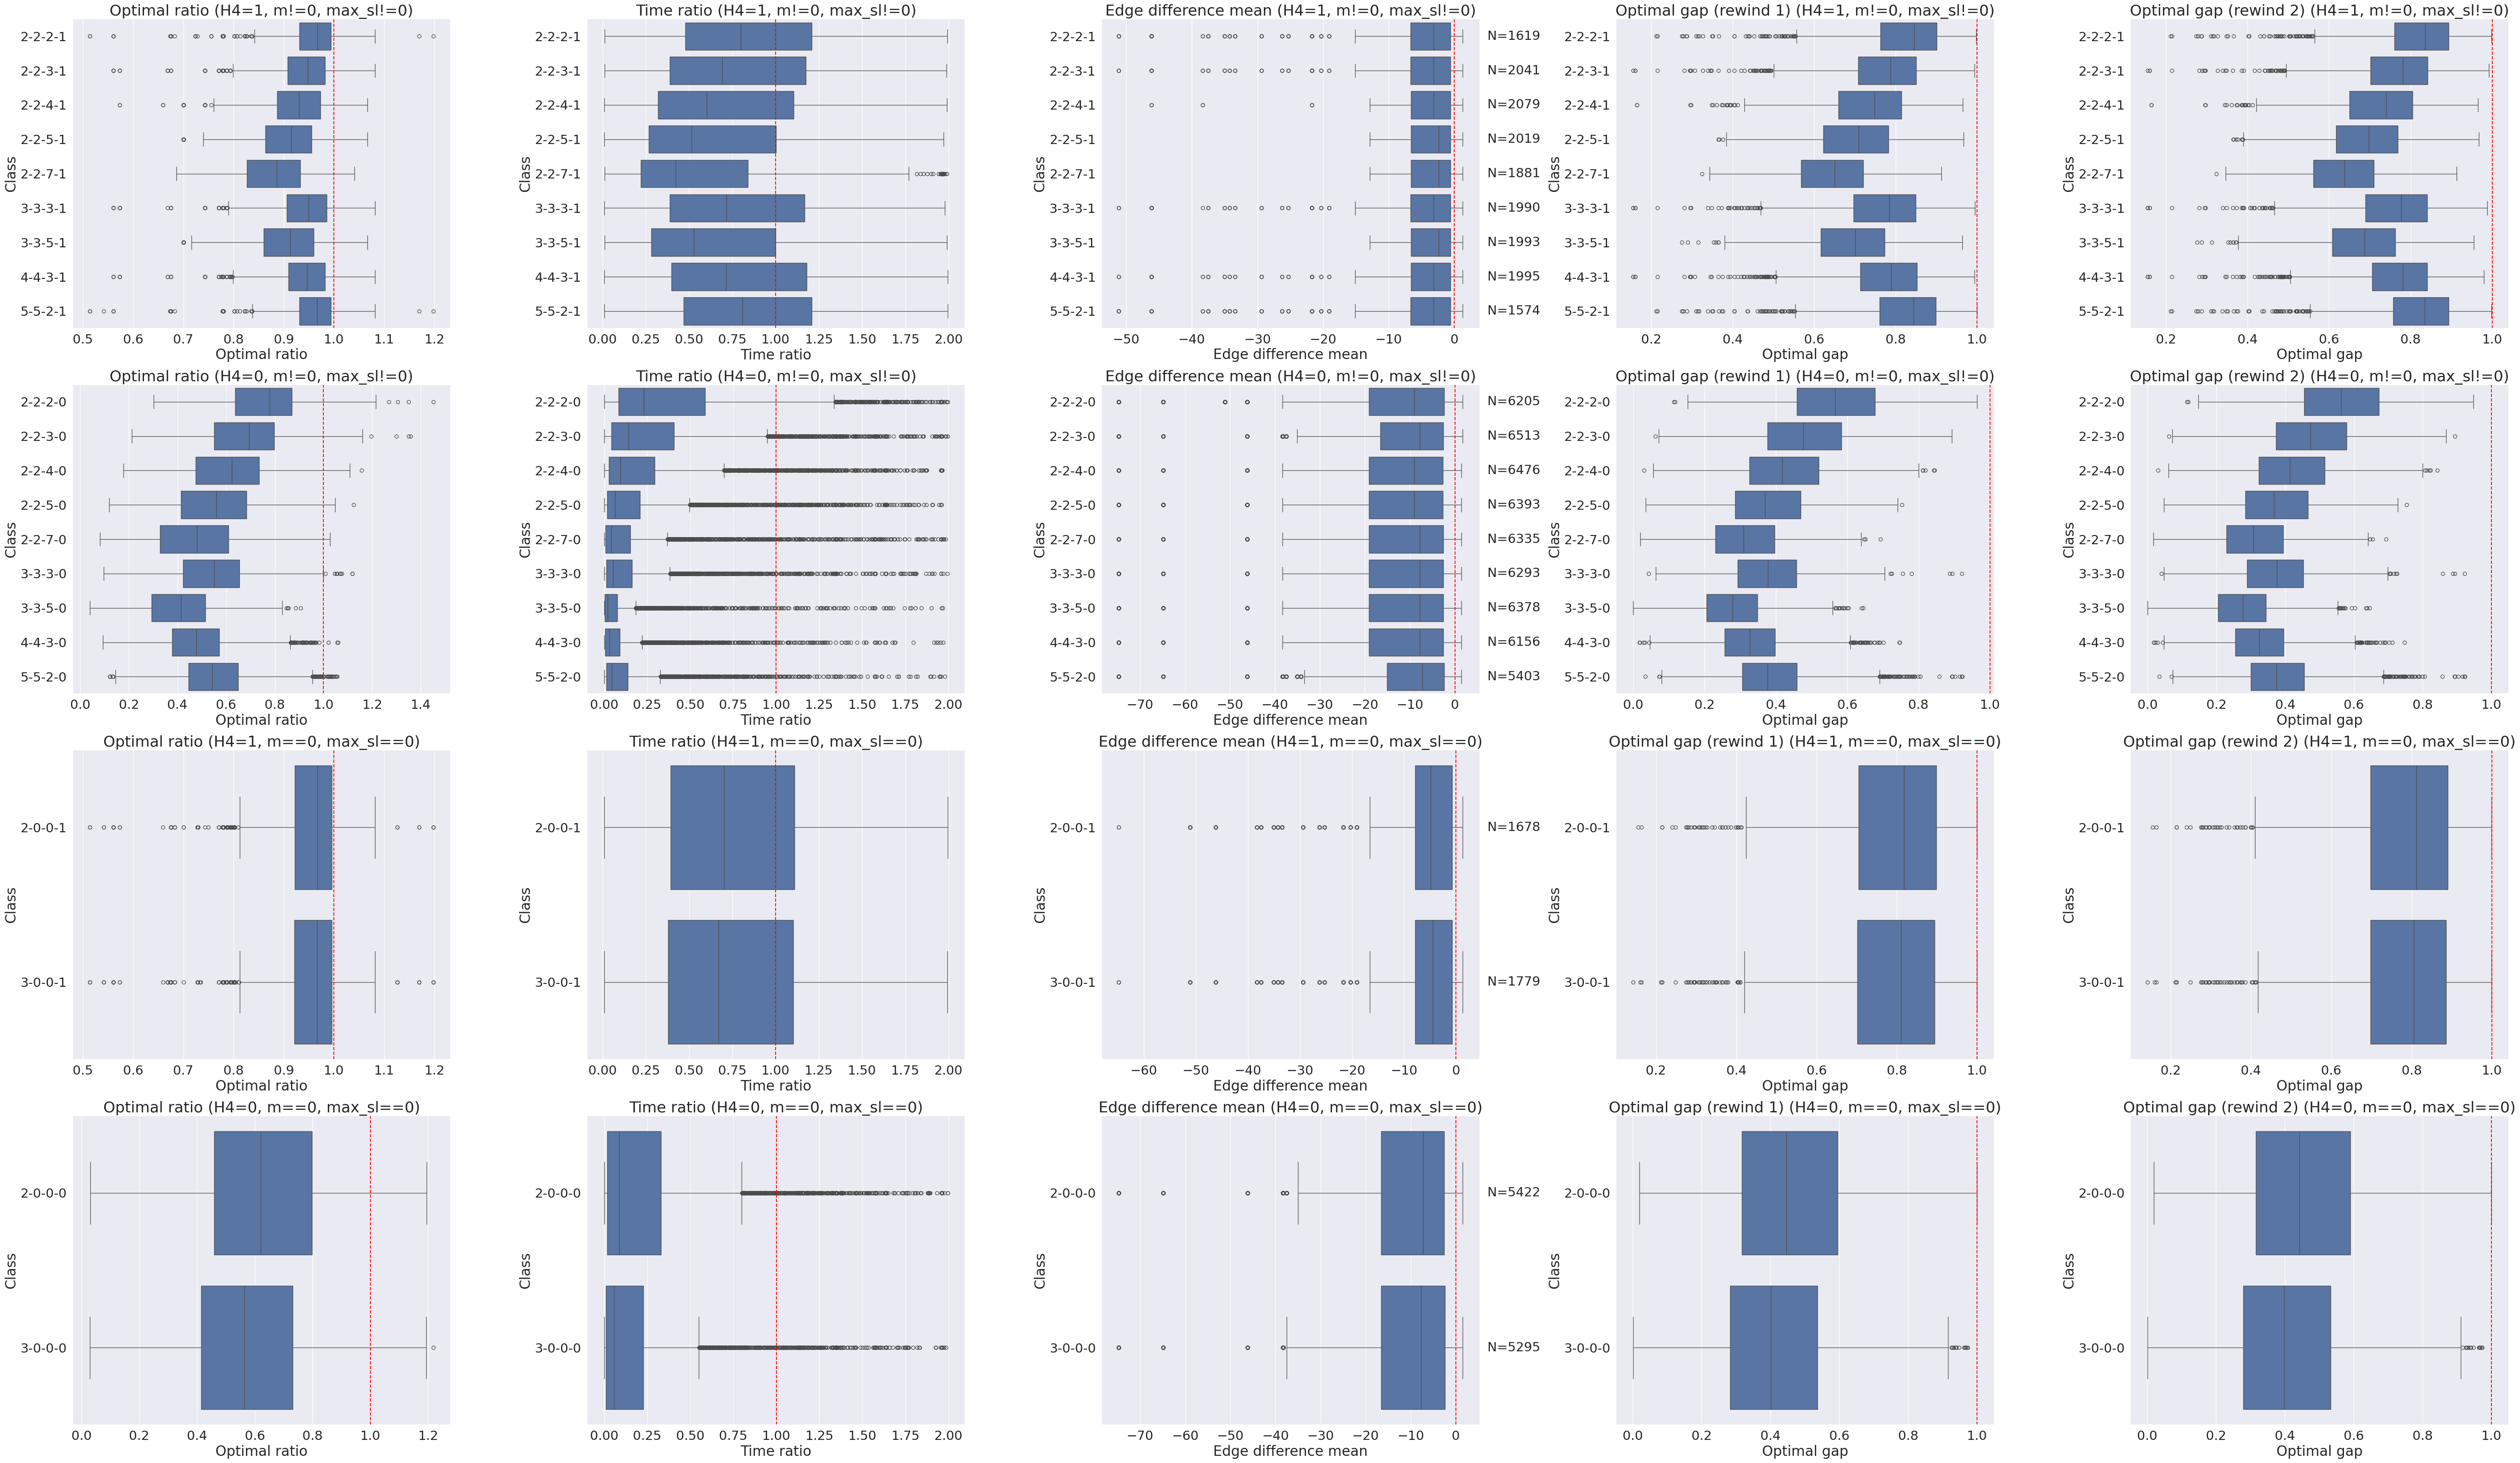

In [6]:
sns.set(style='darkgrid')

plot_kwargs = {
                'ticks_font_size':22,
                'label_font_size':24,
                'title_font_size':26,
                'legend_font_size':22,
                'fig_x_size':15,
                'fig_y_size':10,
                'x_label':'',
                'y_label':'',
                'title':'',
              }


# p = edge_edge_variance_histplot(edge_value_df,problem_name,**plot_kwargs)
# plt.show()
# p = edge_edge_mean_histplot(edge_value_df,problem_name,**plot_kwargs)
# plt.show()
# p = flow_flow_variance_histplot(flow_value_df,problem_name,**plot_kwargs)
# plt.show()
# p = flow_flow_mean_histplot(flow_value_df,problem_name,**plot_kwargs)
# plt.show()
# p = objective_objective_histplot(meta_data_df,problem_name,**plot_kwargs)
# plt.show()
# p = time_histplot(meta_data_df,problem_name,**plot_kwargs)
# plt.show()

#######################
# The big picture
######################
fig, axs = plt.subplots(4, 5, figsize=(60, 35))  # Create a 2x2 grid of subplots

cdt1 = (merged_df['time_ratio']<=2)

cdt2 = (merged_df['H4']==1)
notcdt2 = (merged_df['H4']==0)

cdt3 = (merged_df['m']!=0)
notcdt3 = (merged_df['m']==0)

cdt4 = (merged_df['max_sl']!=0)
notcdt4 = (merged_df['max_sl']==0)
conditions = []
params = []
####################################################################################################################
conditions.append((cdt1 & cdt2 & cdt3 & cdt4))
params.append('(H4=1, m!=0, max_sl!=0)')
####################################################################################################################
conditions.append((cdt1 & (notcdt2) & cdt3 & cdt4))
params.append('(H4=0, m!=0, max_sl!=0)')
####################################################################################################################
conditions.append((cdt1 & cdt2 & (notcdt3) & (notcdt4)))
params.append('(H4=1, m==0, max_sl==0)')
####################################################################################################################
conditions.append((cdt1 & (notcdt2) & (notcdt3) & (notcdt4)))
params.append('(H4=0, m==0, max_sl==0)')
####################################################################################################################

for i, (condition, param) in enumerate(zip(conditions, params)):
    data = merged_df[condition]

    # Optimal ratio
    plot_kwargs['title'] = f'Optimal ratio {param}'
    plot_kwargs['x_label'] = 'Optimal ratio'
    plot_kwargs['ax'] = axs[i, 0]
    plot_kwargs['fig'] = fig
    p = boxplot_plot(data, x_='optimal_ratio', crosshairs=(1,), legend=False, **plot_kwargs)
    
    # Time ratio
    plot_kwargs['title'] = f'Time ratio {param}'
    plot_kwargs['x_label'] = 'Time ratio'
    plot_kwargs['ax'] = axs[i, 1]
    p = boxplot_plot(data, x_='time_ratio', crosshairs=(1,), legend=False, **plot_kwargs)
    
    # Edge difference mean 
    plot_kwargs['title'] = f'Edge difference mean {param}'
    plot_kwargs['x_label'] = 'Edge difference mean'
    plot_kwargs['ax'] = axs[i, 2]
    p = boxplot_plot(data, x_='edge_diff_mean', crosshairs=(0,), legend=True, **plot_kwargs)
    
    # Optimal ratio rewind 1
    plot_kwargs['title'] = f'Optimal gap (rewind 1) {param}'
    plot_kwargs['x_label'] = 'Optimal gap'
    plot_kwargs['ax'] = axs[i, 3]
    p = boxplot_plot(data, x_='optimal_ratio_rewind_1', crosshairs=(1,), legend=False, **plot_kwargs)
    
    # Optimal ratio rewind 2
    plot_kwargs['title'] = f'Optimal gap (rewind 2) {param}'
    plot_kwargs['x_label'] = 'Optimal gap'
    plot_kwargs['ax'] = axs[i, 4]
    p = boxplot_plot(data, x_='optimal_ratio_rewind_2', crosshairs=(1,), legend=False, **plot_kwargs)


plt.savefig('./result/16plot.pdf')
plt.show()
plt.close()

######################
# Optimal ratio rewind 1
data = merged_df[conditions[0]]
plot_kwargs['title'] = f'Optimal gap with locality'
plot_kwargs['x_label'] = r'Optimal gap ($\tilde{x}^* / x^*$)'
plot_kwargs['ax'] = False
plot_kwargs['fig']=False
p = boxplot_plot(data, x_='optimal_ratio_rewind_1', crosshairs=(1,), legend=True, **plot_kwargs)
plt.savefig('./result/box_plot_optimal_gap_h4_1.pdf')
plt.close()

plot_kwargs['title'] = f'Time ratio with locality'
plot_kwargs['x_label'] = r'Time ratio ($\widetilde{T}/T$)'
plot_kwargs['ax'] = False
plot_kwargs['fig']=False
p = boxplot_plot(data, x_='time_ratio_rewind_1', crosshairs=(1,), legend=True, **plot_kwargs)
plt.savefig('./result/box_plot_time_ratio_h4_1.pdf')
plt.close()

data = merged_df[conditions[1]]
plot_kwargs['title'] = f'Optimal gap without locality'
plot_kwargs['x_label'] = r'Optimal gap ($\tilde{x}^* / x^*$)'
plot_kwargs['ax'] = False
plot_kwargs['fig']=False
p = boxplot_plot(data, x_='optimal_ratio_rewind_1', crosshairs=(1,), legend=True, **plot_kwargs)
plt.savefig('./result/box_plot_optimal_gap_h4_0.pdf')
plt.close()

plot_kwargs['title'] = f'Time ratio without locality'
plot_kwargs['x_label'] = r'Time ratio ($\widetilde{T}/T$)'
plot_kwargs['ax'] = False
plot_kwargs['fig']= False
p = boxplot_plot(data, x_='time_ratio_rewind_1', crosshairs=(1,), legend=True, **plot_kwargs)
plt.savefig('./result/box_plot_time_ratio_h4_0.pdf')
plt.close()



(164, 23)
14      0.000000
18      0.043478
19      9.130435
20     -9.304348
28      9.000000
         ...    
807    14.739130
809     2.567789
816     0.217391
818     1.521739
821     1.913043
Length: 164, dtype: float64
14      0.000000
18      0.208514
19     17.633399
20     11.279244
28     12.982506
         ...    
807    11.095525
809     8.701558
816     0.850482
818     6.479826
821     6.653181
Length: 164, dtype: float64


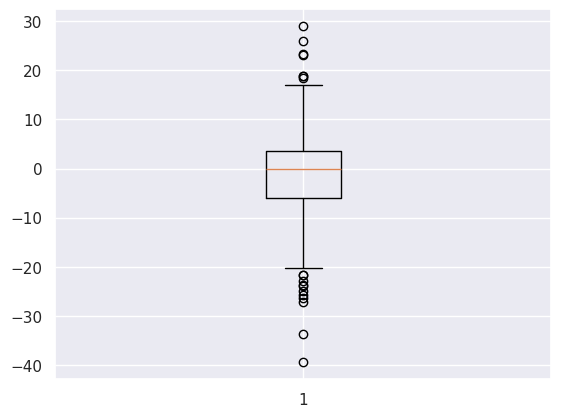

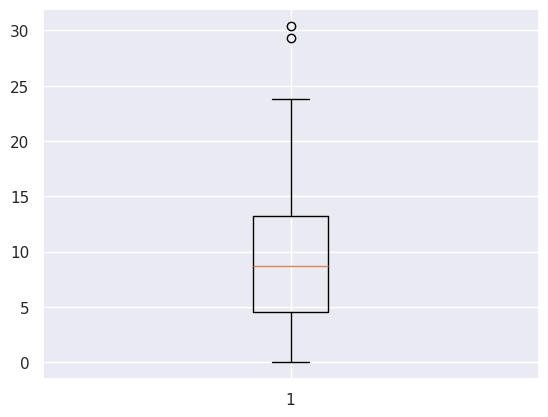

In [7]:
cdt5 = merged_df['optimal_ratio_rewind_1']>=0.85
problem_name = 'd30-08'
cdt6 = merged_df['Class2'] == f'2-2-2-1-{problem_name}'


condition = (cdt1 & cdt2 & cdt3 & cdt4 & cdt5 & cdt6)
data = merged_df[condition]

data = result_dict[problem_name]['edge_value_df'][data.index].copy()
data.insert(0, f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}', result_dict[problem_name]['edge_value_df'][f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}'])

data
test = data.iloc[:,1:].sub(data[f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}'], axis=0)





print(test.shape)
print(test.mean(axis=1))
print(test.std(axis=1))

plt.boxplot(test.mean(axis=1))
plt.show()


plt.boxplot(test.std(axis=1))
plt.show()

# row_std = 
# print(row_means)
# print(row_std.mean())
# data
#
# Optimal ratio H4=1
# plot_kwargs['title'] = 'Edge difference mean (H4=1)'
# plot_kwargs['x_label'] = 'Edge difference mean'
# #p = density_kdeplot(tmp_df[tmp_df['H4'] == 1], x_='time_ratio', crosshairs=(1,), legend=True, **plot_kwargs)
# # plot_kwargs['ax'] = axs[0, 0]
# # plot_kwargs['fig'] = fig
# sns.histplot(merged_df[merged_df['H4'] == 0]['edge_diff_mean'], kde=True, legend=True)


,obj_value,preprocess_time,solve_time,n_vertex,n_edge,n_tolled,compression_factors,rewind_optimal_1,rewind_time_1,rewind_optimal_2,...,time_ratio,time_ratio_rewind_1,time_ratio_rewind_2,tolled_ratio,edge_diff_mean,edge_diff_std,flow_diff_mean,flow_diff_std,Class,Class2
000009-100-3-3-3-1-1-1-0-1500-d30-01,76970.0,1.474321,9.129762,132,828,160,"{1: 1.0072463768115942, 2: 1.0909090909090908,...",68740,0.033259,68740,...,0.033712,0.033834,0.033826,0.963855,-1.911659,12.836517,-4.146107,1.087866,3-3-3-0,3-3-3-0-d30-01
000072-100-3-3-3-1-1-1-0-1500-d30-01,80481.0,1.658453,38.494135,133,828,160,"{1: 1.0072463768115942, 2: 1.0827067669172932,...",45547,0.030208,45057,...,0.142139,0.142251,0.14225,0.963855,-1.911659,12.836517,-4.146107,1.087866,3-3-3-0,3-3-3-0-d30-01
000059-100-3-3-3-1-1-1-0-1500-d30-01,75674.0,2.056887,14.851328,133,828,160,"{1: 1.0072463768115942, 2: 1.0827067669172932,...",57139,0.035501,57139,...,0.054838,0.054969,0.054957,0.963855,-1.911659,12.836517,-4.146107,1.087866,3-3-3-0,3-3-3-0-d30-01
000052-100-3-3-3-1-1-1-0-1500-d30-01,86830.0,2.518023,26.111884,132,828,160,"{1: 1.0072463768115942, 2: 1.0909090909090908,...",55915,0.030575,54195,...,0.096418,0.096531,0.096527,0.963855,-1.911659,12.836517,-4.146107,1.087866,3-3-3-0,3-3-3-0-d30-01
000014-100-3-3-3-1-1-1-0-1500-d30-01,75875.0,0.961159,33.368818,133,828,160,"{1: 1.0072463768115942, 2: 1.0827067669172932,...",56870,0.029971,56870,...,0.123214,0.123325,0.123325,0.963855,-1.911659,12.836517,-4.146107,1.087866,3-3-3-0,3-3-3-0-d30-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000017-100-2-2-5-1-1-1-0-1500-v50-01,123831.0,0.103596,74.367546,134,401,77,"{1: 1.0124688279301746, 2: 1.0746268656716418,...",92962,0.058399,92962,...,0.25594,0.256141,0.256112,0.939024,-11.353089,45.007013,-1.758511,2.358616,2-2-5-0,2-2-5-0-v50-01
000087-100-2-2-5-1-1-1-0-1500-v50-01,106883.0,0.041229,21.278106,134,401,77,"{1: 1.0124688279301746, 2: 1.0746268656716418,...",60675,0.052095,60675,...,0.07323,0.073409,0.073418,0.939024,-11.353089,45.007013,-1.758511,2.358616,2-2-5-0,2-2-5-0-v50-01
000071-100-2-2-5-1-1-1-0-1500-v50-01,123721.0,0.221849,391.260369,134,401,77,"{1: 1.0124688279301746, 2: 1.0746268656716418,...",65342,0.047269,62848,...,1.346545,1.346708,1.346714,0.939024,-11.353089,45.007013,-1.758511,2.358616,2-2-5-0,2-2-5-0-v50-01
000057-100-2-2-5-1-1-1-0-1500-v50-01,118483.0,0.083379,40.982051,134,401,77,"{1: 1.0124688279301746, 2: 1.0746268656716418,...",56926,0.064419,56511,...,0.141042,0.141264,0.141209,0.939024,-11.353089,45.007013,-1.758511,2.358616,2-2-5-0,2-2-5-0-v50-01


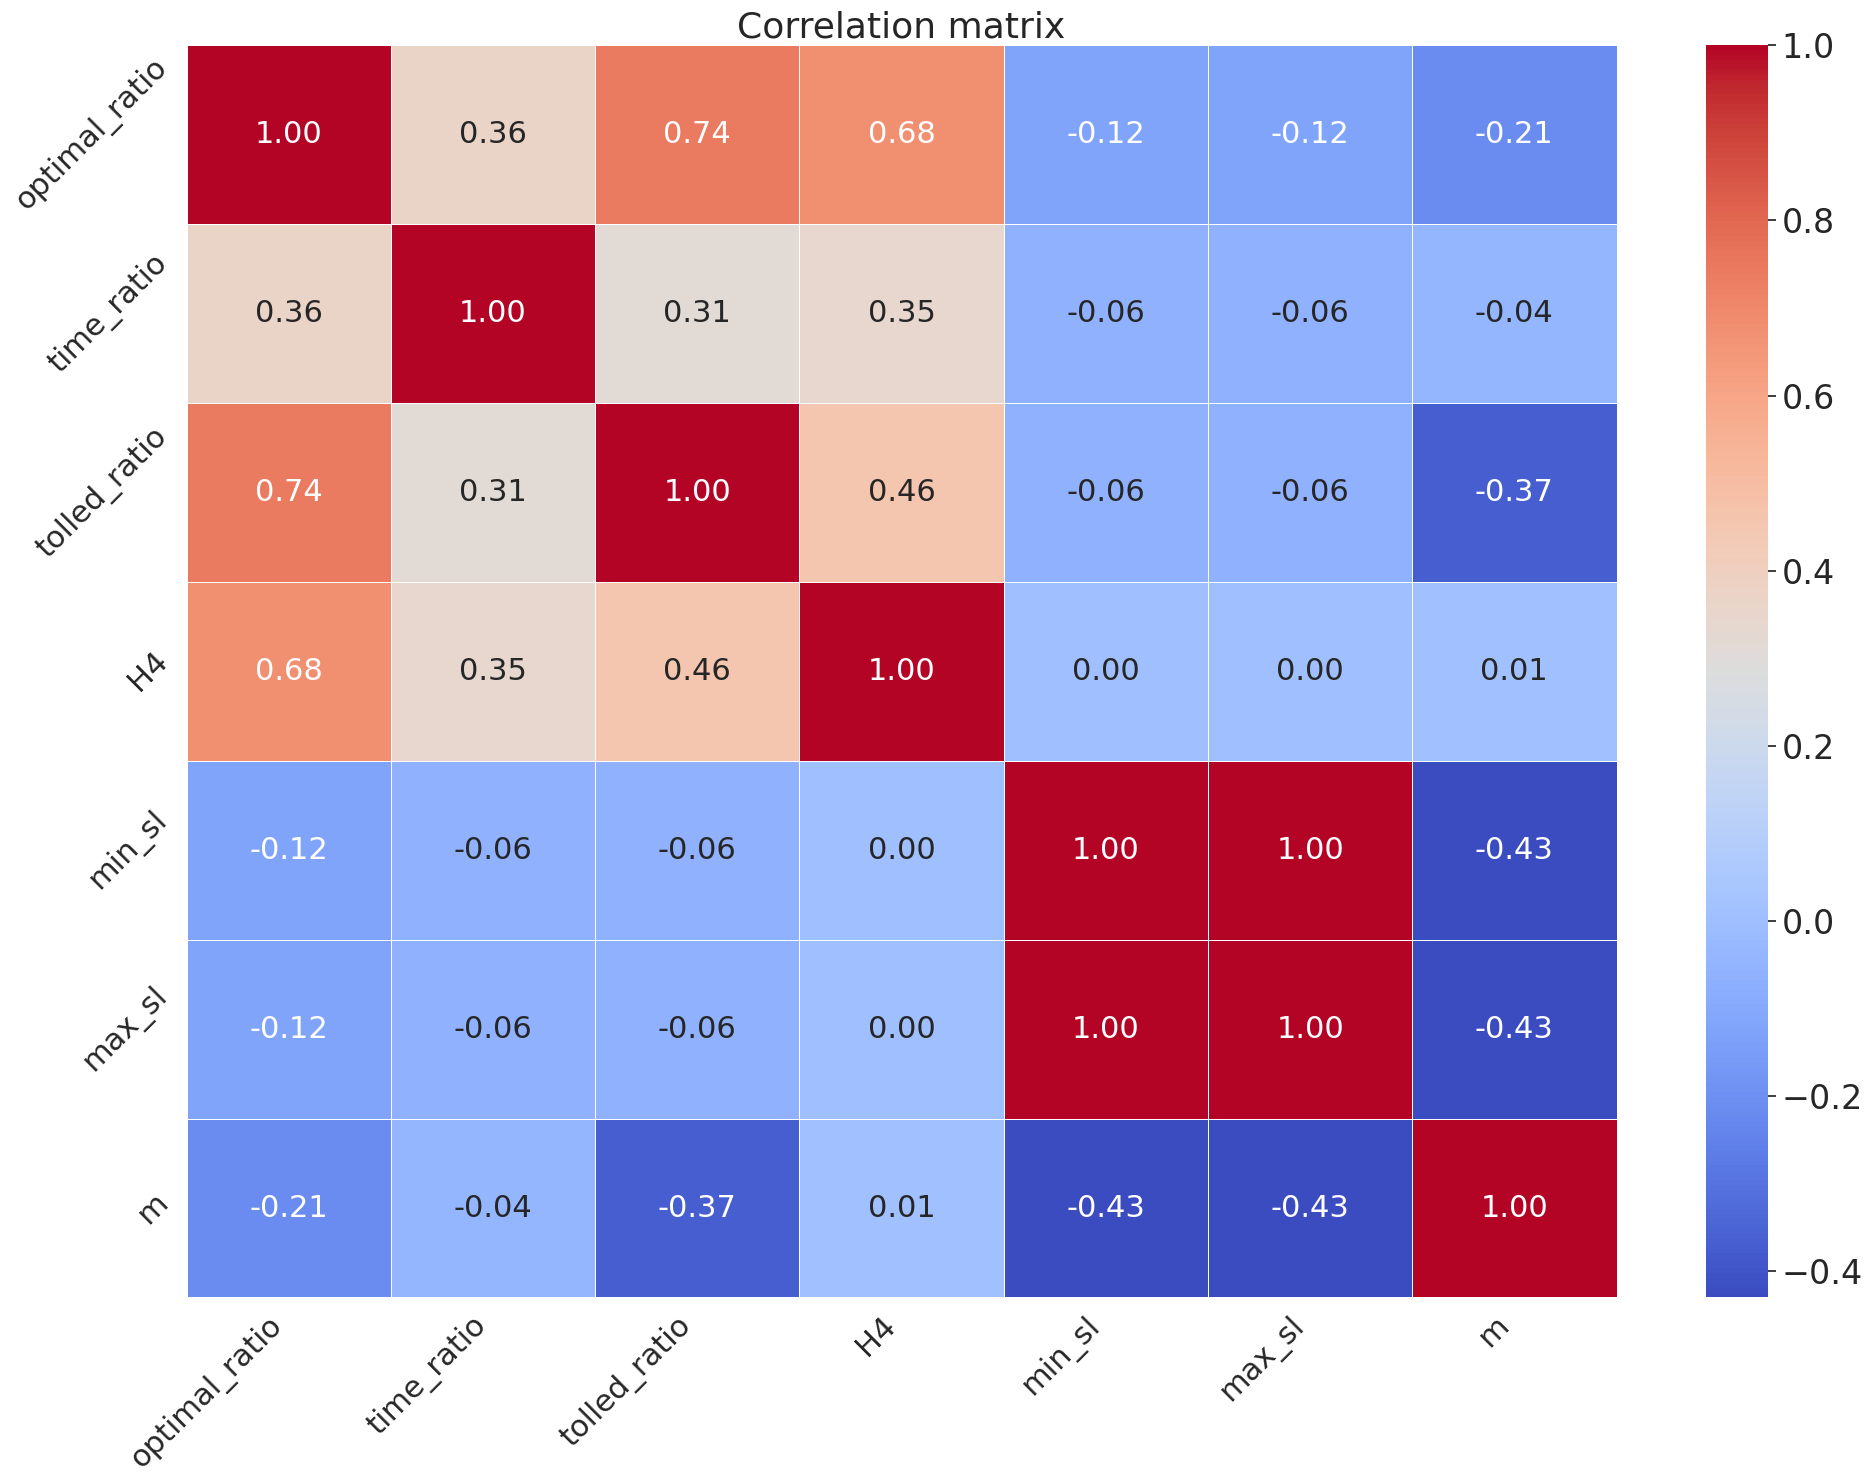

In [8]:
plot_kwargs = {
                'ticks_font_size':22,
                'label_font_size':24,
                'title_font_size':26,
                'legend_font_size':22,
                'fig_x_size':20,
                'fig_y_size':15,
                'x_label':'',
                'y_label':'',
                'title':'',
              }

plot_kwargs['title'] ='Correlation matrix'
p=correlation_matrix(merged_df[(merged_df['max_sl']!=0) & (merged_df['m']!=0)], columns=['optimal_ratio', 'time_ratio', 'tolled_ratio', 'H4', 'min_sl', 'max_sl', 'm'],  **plot_kwargs)


merged_df[(merged_df['max_sl']!=0) & (merged_df['m']!=0)]

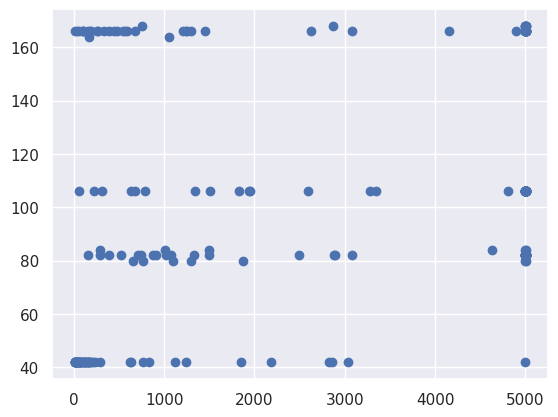

In [40]:
data_test = original_meta_data[original_meta_data['finish']==1].copy()
filtered_df = data_test.query("index.str.contains('v')")

plt.scatter(original_meta_data['solve_time'], original_meta_data['n_tolled'])